# Big Data Cup 2021 
## How to value Zone Entries and other actions that are not shots or goals
### VAEP (Valuing actions by estimating probabilities) framework for Hockey 
Inspired by paper of the Soccer version [Actions Speak Louder Than Goals: Valuing Player Actions in Soccer](https://arxiv.org/abs/1802.07127) by Tom Decroos, Lotte Bransen, Jan Van Haaren and Jesse Davis. Very helpful was the Tutorial as part of the Friends of Tracking initiative by Lotte Bransen and Jan Van Haaren: [Friends of Tracking: Valuing actions in football](https://github.com/SciSports-Labs/fot-valuing-actions)

In [61]:
%reload_ext nb_black
import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import KFold
from xgboost import XGBClassifier, plot_importance

import shap
from ipywidgets import interact_manual, fixed, widgets
%matplotlib inline

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Importing data, renaming columns, creating extra columns

In [62]:
# Import and Data Frame for womens data
project_dir = '/Users/keltim01/git_repos/TK5/Data/Big-Data-Cup-2021/'
womens = pd.read_csv(project_dir + 'hackathon_womens.csv')
nwhl = pd.read_csv(project_dir + 'hackathon_nwhl.csv')
womens = womens.append(nwhl, ignore_index=True)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [63]:
# important numbers for the hockey rink 
ICE_LENGTH = 200
ICE_WIDTH = 85
GOAL_X = ICE_LENGTH - 10
GOAL_Y = ICE_WIDTH / 2
D_ZONE = 75
O_ZONE = ICE_LENGTH - 75

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [64]:
womens.columns = ['game_date', 'home_team', 'away_team', 'period', 'clock', 'home_team_skaters', 'away_team_skaters', 'home_team_goals','away_team_goals', 'team', 'player', 'event', 'x_coord', 'y_coord', 'detail_1', 'detail_2', 'detail_3', 'detail_4', 'player_2', 'x_coord_2', 'y_coord_2']
womens['game_id'] = womens.loc[:, ['game_date', 'home_team', 'away_team']].sum(axis=1).astype('category').cat.codes
womens['is_home'] = 0
womens['is_shot'] = 0
womens['is_goal'] = 0
womens['event_id'] = womens['event'].astype('category').cat.codes
womens['team_id'] = womens['team'].astype('category').cat.codes
womens['player_id'] = womens['player'].astype('category').cat.codes

for x in range(1,5):
    womens[f'detail_{x}_code'] = womens[f'detail_{x}'].astype('category').cat.codes
womens.loc[womens['home_team'] == womens['team'], 'is_home'] = 1
womens.loc[womens['event']=='Shot', 'is_shot'] = 1
womens.loc[womens['event']=='Goal', 'is_goal'] = 1
womens['goal_diff'] = womens['home_team_goals'].sub(womens['away_team_goals'])
womens['clock'] = pd.to_datetime(womens['clock'], format='%M:%S')
womens['seconds_remaining'] = womens['clock'].dt.minute.mul(60).add(womens['clock'].dt.second)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Possession gained/lost
* Shot: which team has the puck recovery? (next event)
* Goal: not interesting because you scored -> 0
* Play: possession stays -> 0
* Incomplete Play: Possession lost -> -1
* Takeaway: Possession won 
* Puck recovery: according to the team Possessing the puck before 
* Dump In/out: team recovering the puck 
* Zone Entry: 
    * carried: possesion retained 
    * dump in: next event 
    * passed: possesion retained 
* Faceoff Win: Possession gained
* Penalty Taken: Possession 0 like goal

## Glossary 
* -1 possesion lost through action 
* 0 possesion stays the same 
* 1 possesion gained through action

In [65]:
womens.loc[(womens['event']=='Shot') & (womens['team']==womens['team'].shift(-1)),'poss_status'] = 0
womens.loc[(womens['event']=='Shot') & (womens['team']!=womens['team'].shift(-1)),'poss_status'] = -1
womens.loc[(womens['event']=='Puck Recovery') & (womens['team']!=womens['team'].shift(1)),'poss_status'] = 1
womens.loc[(womens['event']=='Puck Recovery') & (womens['team']==womens['team'].shift(1)),'poss_status'] = 0
womens.loc[(womens['event']=='Dump In/Out') & (womens['team']==womens['team'].shift(-1)),'poss_status'] = 0
womens.loc[(womens['event']=='Dump In/Out') & (womens['team']!=womens['team'].shift(-1)),'poss_status'] = -1
womens.loc[womens['event']=='Goal','poss_status'] = 0
womens.loc[womens['event']=='Takeaway','poss_status'] = 1
womens.loc[womens['event']=='Play','poss_status'] = 0
womens.loc[womens['event']=='Incomplete Play','poss_status'] = -1
womens.loc[(womens['event']=='Zone Entry') & (womens['detail_1']=='Dumped') & (womens['event'].shift(-1) == 'Faceoff Win'),'poss_status'] = 0
womens.loc[(womens['event']=='Zone Entry') & (womens['detail_1']=='Dumped') & (womens['event'].shift(-1) == 'Penalty Taken'),'poss_status'] = 0
womens.loc[(womens['team']==womens['team'].shift(-1)) & (womens['event']=='Zone Entry'),'poss_status'] = 0
womens.loc[(womens['team']!=womens['team'].shift(-1)) & (womens['event']=='Zone Entry'),'poss_status'] = -1
womens.loc[womens['event']=='Faceoff Win','poss_status'] = 1
womens.loc[womens['event']=='Penalty Taken','poss_status'] = 0

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Strength States: differences between team Strengths 
* 2: possessing team has two skaters more than the opponent 
* 1: possessing team has one skater more than the opponent 
* 0: both teams have an equal number of skaters 
* -1: possessing team has one skater less than the opponent 
* -2: possessing team has two skaters less than the opponent 


In [66]:
womens.loc[womens['team']==womens['home_team'],'strength_state'] = womens.loc[womens['team']==womens['home_team'],'home_team_skaters'].sub(womens.loc[womens['team']==womens['home_team'],'away_team_skaters'])
womens.loc[womens['team']==womens['away_team'],'strength_state'] = womens.loc[womens['team']==womens['away_team'],'away_team_skaters'].sub(womens.loc[womens['team']==womens['away_team'],'home_team_skaters'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  Calculate differences in disctance for actions & create endpoint for actions
### Shot
* on net: position of the goal
* missed/blocked possesion lost or Retained: location next event -> Puck Recovery
### Goal 
* position of the goal
### Takeaway
* same position
### Puck Recovery
* same position
### Dump In/Out
* Possession Lost or Retained: location of the next event (Puck Recovery)
### Zone Entry
* Carried: same position
* Dumped: location of the next event (Puck Recovery)
* Passed: entpoint of the pass
### Faceoff Wins
* same position
### Penalty Taken
* same position

In [67]:
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'On Net'),['x_coord_2','y_coord_2']] = [GOAL_X,GOAL_Y]
shifted_coords = womens.loc[:,['x_coord','y_coord']].shift(-1)
womens2 = womens.loc[:]
womens2.loc[:,['x_coord','y_coord']] = shifted_coords
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'Blocked'),'x_coord_2'] = womens2.loc[(womens2['event']=='Shot') & (womens2['detail_2'] == 'Blocked'),'x_coord']
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'Blocked'),'y_coord_2'] = womens2.loc[(womens2['event']=='Shot') & (womens2['detail_2'] == 'Blocked'),'y_coord']
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'Missed'),'x_coord_2'] = womens2.loc[(womens2['event']=='Shot') & (womens2['detail_2'] == 'Missed'),'x_coord']
womens.loc[(womens['event']=='Shot') & (womens['detail_2'] == 'Missed'),'y_coord_2'] = womens2.loc[(womens2['event']=='Shot') & (womens2['detail_2'] == 'Missed'),'y_coord']
womens.loc[womens['event']=='Goal',['x_coord_2','y_coord_2']] = [GOAL_X,GOAL_Y]
womens.loc[womens['event']=='Takeaway','x_coord_2'] = womens.loc[womens['event']=='Takeaway','x_coord']
womens.loc[womens['event']=='Takeaway','y_coord_2'] = womens.loc[womens['event']=='Takeaway','y_coord']
womens.loc[womens['event']=='Puck Recovery','x_coord_2'] = womens.loc[womens['event']=='Puck Recovery','x_coord']
womens.loc[womens['event']=='Puck Recovery','y_coord_2'] = womens.loc[womens['event']=='Puck Recovery','y_coord']
womens.loc[womens['event']=='Dump In/Out','x_coord_2'] = womens2.loc[womens2['event']=='Dump In/Out','x_coord']
womens.loc[womens['event']=='Dump In/Out','y_coord_2'] = womens2.loc[womens2['event']=='Dump In/Out','y_coord']
womens.loc[womens['event']=='Zone Entry','x_coord_2'] = womens.loc[womens['event']=='Zone Entry','x_coord']
womens.loc[womens['event']=='Zone Entry','y_coord_2'] = womens.loc[womens['event']=='Zone Entry','y_coord']
womens.loc[(womens['event']=='Zone Entry') & (womens['detail_1']=='Dumped'),'x_coord_2'] = womens2.loc[(womens2['event']=='Zone Entry') & (womens2['detail_1']=='Dumped'),'x_coord']
womens.loc[(womens['event']=='Zone Entry') & (womens['detail_1']=='Dumped'),'y_coord_2'] = womens2.loc[(womens2['event']=='Zone Entry') & (womens2['detail_1']=='Dumped'),'y_coord']
womens.loc[womens['event']=='Faceoff Win','x_coord_2'] = womens.loc[womens['event']=='Faceoff Win','x_coord']
womens.loc[womens['event']=='Faceoff Win','y_coord_2'] = womens.loc[womens['event']=='Faceoff Win','y_coord']
womens.loc[womens['event']=='Penalty Taken','x_coord_2'] = womens.loc[womens['event']=='Penalty Taken','x_coord']
womens.loc[womens['event']=='Penalty Taken','y_coord_2'] = womens.loc[womens['event']=='Penalty Taken','y_coord']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## make columns for in which zone a player is in and a diff column for it 
* 1 is the defensive zone 
* 2 is the neutral zone 
* 3 is the offensive zone
* a positive difference is the difference in zones forward
* a negative difference is the differene in zone backwards

In [68]:
womens.loc[womens['x_coord'] <= D_ZONE, 'zone_1'] = 1
womens.loc[womens['x_coord'] > D_ZONE, 'zone_1'] = 2
womens.loc[womens['x_coord'] >= O_ZONE, 'zone_1'] = 3
womens.loc[womens['x_coord_2'] <= D_ZONE, 'zone_2'] = 1
womens.loc[womens['x_coord_2'] > D_ZONE, 'zone_2'] = 2
womens.loc[womens['x_coord_2'] >= O_ZONE, 'zone_2'] = 3
womens.loc[womens['event']=='Zone Entry','zone_1'] = 2
womens.loc[womens['event']=='Zone Entry','zone_2'] = 3
womens.loc[:,'zone_diff'] = womens['zone_2'] - womens['zone_1']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Calculate the distances and angles to the goals at the beginning and the end of the event

In [69]:
diff_x1 = GOAL_X - womens['x_coord']
diff_y1 = abs(GOAL_Y - womens['y_coord'])
diff_x2 = GOAL_X - womens['x_coord_2']
diff_y2 = abs(GOAL_Y - womens['y_coord_2'])
womens['start_distance_to_goal'] = np.sqrt(diff_x1 ** 2 + diff_y1 ** 2)
womens['end_distance_to_goal'] = np.sqrt(diff_x2 ** 2 + diff_y2 ** 2)
womens['diff_x'] = womens['x_coord_2'] - womens['x_coord']
womens['diff_y'] = womens['y_coord_2'] - womens['y_coord']
womens['distance_covered'] = np.sqrt((womens['x_coord_2'] - womens['x_coord']) ** 2 + (womens['y_coord_2'] - womens['y_coord']) ** 2)
diff_x1 = diff_x1.astype(float)
womens['angle_to_goal_start'] = np.divide(diff_x1, diff_y1,out=np.zeros_like(diff_x1),where=(diff_y1 != 0))
womens.loc[womens['angle_to_goal_start']>=360,'angle_to_goal_start'] = womens.loc[womens['angle_to_goal_start'] >=360,'angle_to_goal_start'] - 360
womens.loc[womens['angle_to_goal_start']< 0,'angle_to_goal_start'] = womens.loc[womens['angle_to_goal_start'] < 0,'angle_to_goal_start'] + 360
diff_x2 = diff_x2.astype(float)
womens['angle_to_goal_end'] = np.divide(diff_x2, diff_y2,out=np.zeros_like(diff_x2),where=(diff_y2 != 0))
womens.loc[womens['angle_to_goal_end']>=360,'angle_to_goal_end'] = womens.loc[womens['angle_to_goal_end'] >=360,'angle_to_goal_end'] - 360
womens.loc[womens['angle_to_goal_end']< 0,'angle_to_goal_end'] = womens.loc[womens['angle_to_goal_end'] < 0,'angle_to_goal_end'] + 360
womens['diff_angle_to_goal'] = womens['angle_to_goal_end'] - womens['angle_to_goal_start']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# non-shot xG models 
Assigns an xG value to every single event in the dataset even if it isn't a shot. The idea is to put a value on how dangerous a shot would be if taken in that position. 

In [70]:
xg_features = ['x_coord','y_coord','start_distance_to_goal','angle_to_goal_start','strength_state']
xg_labels = ['is_goal']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [71]:
parameters = {
    'nthread': [4],
    'objective': ['binary:logistic'],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01],
    'n_estimators': [100, 500, 1000],
    'seed': [42]
    }

df_xg_model = pd.DataFrame()
kf = KFold(10, shuffle=True)

for train_idx, test_idx in kf.split(womens):
    train_data = womens.iloc[train_idx].copy()
    test_data = womens.iloc[test_idx].copy()

    classifier = XGBClassifier()
    classifier = GridSearchCV(classifier, parameters, scoring='roc_auc', verbose=2)
    classifier.fit(
        train_data[xg_features],
        train_data[xg_labels]
    )
    dfs_predictions = {}
    y_pred = classifier.predict_proba(test_data[xg_features])
    dfs_predictions[xg_labels[0]] = pd.Series(y_pred[:,1], index=test_data.index)
    df_predictions = pd.concat(dfs_predictions, axis=1)
    df_xg_model = df_xg_model.append(df_predictions)

arning_rate=0.01, max_depth=3, n_estimators=1000, nthread=4, objective=binary:logistic, seed=42; total time=   2.8s
[02:45:00] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=3, n_estimators=1000, nthread=4, objective=binary:logistic, seed=42; total time=   2.8s
[02:45:03] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV] END learning_rate=0.01, max_depth=3, n_estimators=1000, nthread=4, objective=binary:logistic, seed=42; total time=   2.8s
[02:45:05] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.c

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [72]:
womens['non_shot_xg'] = df_xg_model['is_goal']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# VAEP - Model 

# Features 
The features the model should use to predict a goal being scored or conceded. Like in the original vaep paper for soccer (linked in the introduction to the notebook) we are using the last 3 actions for predicting a score/concede in the next 10 actions. 

In [73]:
features = ['game_id','team_id', 'player_id', 'period', 'x_coord', 'y_coord', 'x_coord_2',
       'y_coord_2', 'is_home', 'is_shot', 'is_goal', 'event_id',
       'goal_diff', 'seconds_remaining','diff_x', 'diff_y', 'distance_covered', 'start_distance_to_goal', 'end_distance_to_goal','zone_diff','poss_status','diff_angle_to_goal','non_shot_xg']
df_delays = [womens[features].shift(step).add_suffix(f'-{step}') for step in range(0,3)]
df_features = pd.concat(df_delays, axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
for step in range(0,3):
    df_features[f'team-{step}'] = df_features['team_id-0'] == df_features[f'team_id-{step}']

for step in range(0,3):
    df_features.loc[~(df_features[f'team-{step}']),f'x_coord-{step}'] = ICE_LENGTH - df_features[f'x_coord-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'x_coord_2-{step}'] = ICE_LENGTH - df_features[f'x_coord_2-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'y_coord-{step}'] = ICE_WIDTH - df_features[f'y_coord-{step}']
    df_features.loc[~(df_features[f'team-{step}']),f'y_coord_2-{step}'] = ICE_WIDTH - df_features[f'y_coord_2-{step}']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [75]:
for step in range(0,3):
    start_diff_x = GOAL_X - df_features[f'x_coord-{step}']
    start_diff_y = abs(GOAL_Y - df_features[f'y_coord-{step}'])
    df_features[f'start_distance_to_goal-{step}'] = np.sqrt(start_diff_x ** 2 + start_diff_y ** 2)
    end_diff_x = GOAL_X - df_features[f'x_coord_2-{step}']
    end_diff_y = abs(GOAL_Y - df_features[f'y_coord_2-{step}'])
    df_features[f'end_distance_to_goal-{step}'] = np.sqrt(end_diff_x ** 2 + end_diff_y ** 2)
    df_features[f'diff_x-{step}'] = df_features[f'x_coord_2-{step}'] - df_features[f'x_coord-{step}']
    df_features[f'diff_y-{step}'] = df_features[f'y_coord_2-{step}'] - df_features[f'y_coord-{step}']
    df_features[f'distance_covered-{step}'] = np.sqrt((df_features[f'x_coord_2-{step}'] - df_features[f'x_coord-{step}']) ** 2 + (df_features[f'y_coord_2-{step}'] - df_features[f'y_coord-{step}']) ** 2)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [76]:
df_features['xdiff_sequenc_pre'] = df_features['x_coord-0'] - df_features['x_coord-2']
df_features['ydiff_sequenc_pre'] = df_features['y_coord-0'] - df_features['y_coord-2']
df_features['time_sequence_pre'] = df_features['seconds_remaining-0'] - df_features['seconds_remaining-2']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Labels 
the model should make the predictions on the labels scores and concedes for every action. 

In [77]:
goals = womens['event'].str.contains('Goal')
y = pd.concat([womens.loc[:, 'is_goal'], womens.loc[:,'team_id']], axis = 1)
y.columns = ['goal','team_id']
for i in range(1, 10):
    for col in ['team_id', 'goal']:
        shifted = y[col].shift(-i)
        shifted[-i:] = y[col][len(y) - 1]
        y[f'{col}+{i}'] = shifted.astype(int)

scores = y['goal']
concedes = y['goal']
for i in range(1, 10):
    goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
    goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
    scores = scores | goal_scored
    concedes = concedes | goal_opponent
label_scores = pd.DataFrame(scores, columns=['scores'])
label_concedes = pd.DataFrame(concedes, columns=['concedes'])
df_labels = pd.concat([label_scores, label_concedes], axis=1)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Modelling the score and concede values 

In [78]:
labels = ['scores','concedes']
feat = ['start_distance_to_goal-0', 'end_distance_to_goal-0', 'start_distance_to_goal-1', 'end_distance_to_goal-1', 'start_distance_to_goal-2', 'end_distance_to_goal-2','team-1', 'team-2','seconds_remaining-0','goal_diff-0','zone_diff-0','zone_diff-1','zone_diff-2','poss_status-0','poss_status-1','poss_status-2', 'diff_angle_to_goal-0','diff_angle_to_goal-1','diff_angle_to_goal-2','non_shot_xg-0','non_shot_xg-1','non_shot_xg-2']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [79]:
df_model = pd.concat([df_features,df_labels],axis=1)
df_score_concede_prob = pd.DataFrame()
kf = KFold(10, shuffle=True)

for train_idx, test_idx in kf.split(df_model):
    train_data = df_model.iloc[train_idx].copy()
    test_data = df_model.iloc[test_idx].copy()

    models = {}
    for label in tqdm(labels):
        model = XGBClassifier(
            n_estimators=50,
            max_depth=3
        )
        model.fit(
            X=train_data[feat],
            y=train_data[label]
        )
        models[label] = model

    dfs_predictions = {}
    for label in tqdm(labels):
        model = models[label]
        probabilities = model.predict_proba(test_data[feat])
        predictions = probabilities[:, 1]
        print(np.isnan(probabilities).sum())
        dfs_predictions[label] = pd.Series(predictions, index=test_data.index)
    df_predictions = pd.concat(dfs_predictions, axis=1)
    df_score_concede_prob = df_score_concede_prob.append(df_predictions)

  0%|          | 0/2 [00:00<?, ?it/s]0
0
[02:46:46] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/2 [00:00<?, ?it/s]0
0
[02:46:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/2 [00:00<?, ?it/s]0
0
[02:46:49] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  0%|          | 0/2 [00:00<?, 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [80]:
dfs_actions = []
dfs_actions.append(womens)
df_actions = pd.concat(dfs_actions).reset_index(drop=True)

df_actions_predictions = pd.concat([df_actions, df_score_concede_prob], axis=1)
df_actions_predictions = df_actions_predictions.dropna(subset=['start_distance_to_goal', 'end_distance_to_goal', 'diff_x', 'diff_y',
       'distance_covered', 'scores', 'concedes'])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## calculate the final VAEP value from score and conced

In [81]:
def prev(x: pd.Series) -> pd.Series:
    prev_x = x.shift(1)
    prev_x[:1] = x.values[0]
    return prev_x

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
dfs_values = []
df_values = pd.DataFrame()

sameteam = prev(df_actions_predictions.team_id) == df_actions_predictions.team_id
prev_scores = prev(df_actions_predictions.scores) * sameteam + prev(df_actions_predictions.concedes) * (~sameteam)
prev_concedes = prev(df_actions_predictions.concedes) * sameteam + prev(df_actions_predictions.scores) * (~sameteam)

toolong_idx = abs(prev(df_actions_predictions.seconds_remaining) - df_actions_predictions.seconds_remaining) > 10
prev_scores[toolong_idx] = 0
prev_concedes[toolong_idx] = 0

prevgoal_idx = prev(df_actions_predictions.event) == 'Goal'
prev_scores[prevgoal_idx] = 0
prev_concedes[prevgoal_idx] = 0

df_values['offensive_value'] = df_actions_predictions.scores - prev_scores
df_values['defensive_value'] = df_actions_predictions.concedes - prev_concedes
df_values['vaep'] = df_values['offensive_value'] + df_values['defensive_value']

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Analysing the values with focus on Zone Entries

In [201]:
df_final = pd.concat([df_actions_predictions,df_values],axis=1).dropna(subset=['vaep'])
df_ranking = (df_final[['player','team','vaep']]
.groupby(['player','team'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'))
.sort_values('vaep_sum',ascending=False)
.reset_index()
)

df_rank_events = (df_final[['event','vaep']]
.groupby(['event'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'))
.sort_values('vaep_sum',ascending=False)
.reset_index()
)

df_zone_entries = (df_final.loc[df_final['event']=='Zone Entry',['detail_1','defensive_value','offensive_value','vaep','poss_status']]
.groupby(['detail_1'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'),
poss_sum=('poss_status','sum'),
poss_mean=('poss_status','mean'))
.sort_values('vaep_sum',ascending=False)
.reset_index()
)

df_rank_strength = (df_final[['strength_state','event','vaep']]
.groupby(['strength_state','event'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'))
.sort_values('vaep_sum',ascending=False)
.reset_index()
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
df_ranking.head(10)

,player,team,vaep_count,vaep_mean,vaep_sum
0,Natalie Spooner,Olympic (Women) - Canada,411,0.014405,5.920354
1,Kendall Coyne Schofield,Olympic (Women) - United States,466,0.008720,4.063686
2,Rebecca Johnston,Olympic (Women) - Canada,686,0.005900,4.047698
3,Christina Putigna,Boston Pride,365,0.009740,3.555100
4,Marie-Philip Poulin,Olympic (Women) - Canada,657,0.005033,3.306853
5,Meghara McManus,Boston Pride,219,0.014596,3.196632
6,Autumn MacDougall,Buffalo Beauts,285,0.010980,3.129389
7,Meghan Agosta,Olympic (Women) - Canada,324,0.008394,2.719556
8,McKenna Brand,Boston Pride,439,0.005778,2.536663
9,Meghan Lorence,Minnesota Whitecaps,229,0.010895,2.494891


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [85]:
df_rank_events

,event,vaep_count,vaep_mean,vaep_sum
0,Shot,3524,0.041460,146.105148
1,Play,14673,0.003836,56.291195
2,Goal,132,0.397460,52.464661
3,Zone Entry,3744,0.004974,18.622719
4,Takeaway,2092,0.001271,2.659031
5,Dump In/Out,3545,0.000500,1.774245
6,Penalty Taken,260,0.003322,0.863661
7,Incomplete Play,6111,-0.007874,-48.119503
8,Faceoff Win,1629,-0.032041,-52.194798
9,Puck Recovery,15174,-0.007052,-107.005989


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Zone Entry Analysis

In [202]:
df_zone_entries

,detail_1,vaep_count,vaep_mean,vaep_sum,poss_sum,poss_mean
0,Carried,2316,0.008142,18.857147,-442.0,-0.190846
1,Dumped,1167,0.000643,0.750766,-954.0,-0.817481
2,Played,261,-0.003775,-0.985194,-63.0,-0.241379


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [87]:
df_final_ze = df_final.loc[df_final['event']=='Zone Entry']
df_final_ze.columns

Index(['game_date', 'home_team', 'away_team', 'period', 'clock',
       'home_team_skaters', 'away_team_skaters', 'home_team_goals',
       'away_team_goals', 'team', 'player', 'event', 'x_coord', 'y_coord',
       'detail_1', 'detail_2', 'detail_3', 'detail_4', 'player_2', 'x_coord_2',
       'y_coord_2', 'game_id', 'is_home', 'is_shot', 'is_goal', 'event_id',
       'team_id', 'player_id', 'detail_1_code', 'detail_2_code',
       'detail_3_code', 'detail_4_code', 'goal_diff', 'seconds_remaining',
       'poss_status', 'strength_state', 'zone_1', 'zone_2', 'zone_diff',
       'start_distance_to_goal', 'end_distance_to_goal', 'diff_x', 'diff_y',
       'distance_covered', 'angle_to_goal_start', 'angle_to_goal_end',
       'diff_angle_to_goal', 'non_shot_xg', 'scores', 'concedes',
       'offensive_value', 'defensive_value', 'vaep'],
      dtype='object')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [88]:
df_final_ze[['detail_1','team','player','vaep','offensive_value','defensive_value','seconds_remaining',]].sort_values('vaep',ascending=False).head(10)

,detail_1,team,player,vaep,offensive_value,defensive_value,seconds_remaining
25637,Carried,Boston Pride,Samantha Davis,0.126701,0.041948,0.084752,35
30908,Carried,Boston Pride,Meaghan Rickard,0.095021,0.097016,-0.001994,535
46984,Carried,Boston Pride,Kaleigh Fratkin,0.088601,0.110978,-0.022377,828
7166,Carried,Olympic (Women) - United States,Hilary Knight,0.085116,0.089723,-0.004607,867
19553,Carried,Olympic (Women) - Canada,Blayre Turnbull,0.080245,0.060385,0.019861,40
3485,Carried,Olympic (Women) - Finland,Susanna Tapani,0.077579,0.080844,-0.003265,28
1156,Dumped,Olympic (Women) - Canada,Emily Clark,0.072022,0.072966,-0.000944,42
48498,Carried,Toronto Six,Sarah-Eve Coutu Godbout,0.070897,0.071394,-0.000497,87
24159,Carried,Boston Pride,Tori Sullivan,0.067875,0.072819,-0.004944,886
50440,Dumped,Boston Pride,Taylor Wenczkowski,0.064749,0.066148,-0.001399,1050


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [170]:
df_ranking_ze_mean = (df_final_ze[['player','team','vaep','offensive_value','defensive_value']]
.groupby(['player','team'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'),
off_value_mean=('offensive_value','mean'),
off_value_sum=('offensive_value','sum'),
def_value_mean=('defensive_value','mean'),
def_value_sum=('defensive_value','sum'))
.sort_values('vaep_mean',ascending=False)
.reset_index()
)

df_ranking_ze_sum = (df_final_ze[['player','team','vaep','offensive_value','defensive_value']]
.groupby(['player','team'])
.agg(vaep_count=('vaep','count'),
vaep_mean=('vaep','mean'),
vaep_sum=('vaep','sum'),
off_value_mean=('offensive_value','mean'),
off_value_sum=('offensive_value','sum'),
def_value_mean=('defensive_value','mean'),
def_value_sum=('defensive_value','sum'))
.sort_values('vaep_sum',ascending=False)
.reset_index()
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [171]:
df_ranking_ze_mean.loc[df_ranking_ze_mean['vaep_count'] > 10].head(10)

,player,team,vaep_count,vaep_mean,vaep_sum,off_value_mean,off_value_sum,def_value_mean,def_value_sum
5,Tori Sullivan,Boston Pride,21,0.014609,0.306791,0.011983,0.251639,0.002626,0.055152
10,Susanna Tapani,Olympic (Women) - Finland,24,0.012132,0.291160,0.011857,0.284561,0.000275,0.006599
13,Rachael Smith,St. Lawrence Saints,13,0.011870,0.154308,0.013121,0.170576,-0.001251,-0.016268
14,Alyson Matteau,Buffalo Beauts,17,0.011536,0.196118,0.013719,0.233218,-0.002182,-0.037100
15,Mackenzie Lancaster,Connecticut Whale,17,0.011511,0.195695,0.012639,0.214863,-0.001127,-0.019167
17,Blayre Turnbull,Olympic (Women) - Canada,44,0.010621,0.467322,0.009860,0.433850,0.000761,0.033472
18,Carlee Turner,Boston Pride,20,0.010542,0.210840,0.011347,0.226950,-0.000805,-0.016110
19,Marie-Jo Pelletier,Buffalo Beauts,20,0.010514,0.210287,0.009605,0.192110,0.000909,0.018177
20,Breanne Wilson-Bennett,Toronto Six,29,0.010378,0.300970,0.010583,0.306921,-0.000205,-0.005951
24,Mary Parker,Boston Pride,15,0.010179,0.152687,0.010462,0.156930,-0.000283,-0.004243


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [91]:
df_ranking_ze.head(10)

,player,team,vaep_count,vaep_mean,vaep_sum
0,Blayre Turnbull,Olympic (Women) - Canada,44,0.010621,0.467322
1,Mikyla Grant-Mentis,Toronto Six,58,0.007344,0.425945
2,Rebecca Johnston,Olympic (Women) - Canada,78,0.005332,0.415920
3,McKenna Brand,Boston Pride,55,0.006861,0.377375
4,Sarah Nurse,Olympic (Women) - Canada,61,0.005969,0.364129
5,Tereza Vanisova,Boston Pride,62,0.005651,0.350347
6,Samantha Davis,Boston Pride,54,0.006299,0.340170
7,Brianna Decker,Olympic (Women) - United States,45,0.007459,0.335672
8,Hilary Knight,Olympic (Women) - United States,57,0.005738,0.327078
9,Tori Sullivan,Boston Pride,21,0.014609,0.306791


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

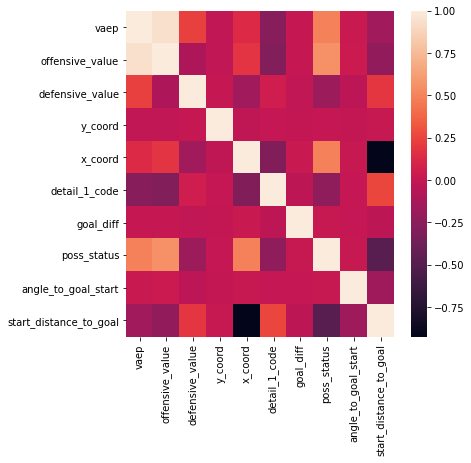

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [92]:
plt.figure(figsize=(6,6))
sns.heatmap(df_final_ze[['vaep','offensive_value','defensive_value','y_coord','x_coord','detail_1_code','goal_diff','poss_status','angle_to_goal_start','start_distance_to_goal']].corr())

In [172]:
df_ranking_ze_mean.head(10)

,player,team,vaep_count,vaep_mean,vaep_sum,off_value_mean,off_value_sum,def_value_mean,def_value_sum
0,Ella Viitasuo,Olympic (Women) - Finland,1,0.028960,0.028960,0.031581,0.031581,-0.002621,-0.002621
1,Diana Kanayeva,Olympic (Women) - Olympic Athletes from Russia,4,0.019125,0.076501,0.020335,0.081339,-0.001209,-0.004838
2,Sara Sakkinen,Olympic (Women) - Finland,4,0.017850,0.071400,0.019064,0.076258,-0.001215,-0.004858
3,Allie Olnowich,Metropolitan Riveters,3,0.017649,0.052946,0.015158,0.045473,0.002491,0.007473
4,Lisa Chesson,Buffalo Beauts,4,0.015591,0.062363,0.015974,0.063894,-0.000383,-0.001531
5,Tori Sullivan,Boston Pride,21,0.014609,0.306791,0.011983,0.251639,0.002626,0.055152
6,Sarah Hughson,Connecticut Whale,1,0.014091,0.014091,0.015198,0.015198,-0.001107,-0.001107
7,Winny Brodt-Brown,Minnesota Whitecaps,6,0.013829,0.082976,0.015685,0.094111,-0.001856,-0.011135
8,Briana Mastel,Boston Pride,2,0.012611,0.025222,0.011328,0.022655,0.001283,0.002567
9,Cailey Hutchison,Metropolitan Riveters,2,0.012220,0.024439,0.009570,0.019140,0.002650,0.005299


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [175]:
df_ranking_ze_mean_min10 = df_ranking_ze_mean.loc[df_ranking_ze_mean['vaep_count'] >= 10].reset_index()
df_ranking_ze_sum_min10 = df_ranking_ze_sum.loc[df_ranking_ze_sum['vaep_count'] >= 10].reset_index()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

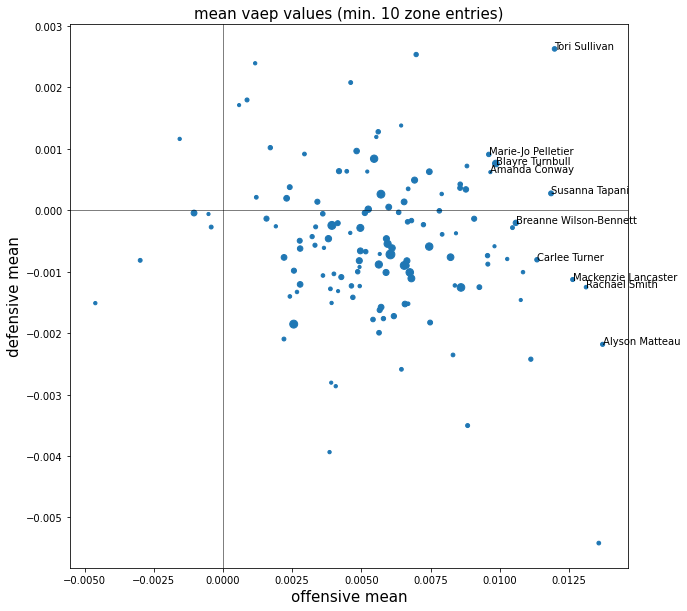

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [204]:
fig, ax = plt.subplots(figsize=(10,10))
plt.scatter(df_ranking_ze_mean_min10['off_value_mean'],df_ranking_ze_mean_min10['def_value_mean'],s=df_ranking_ze_mean_min10['vaep_count'])
ax.set_xlabel('offensive mean', fontsize=15)
ax.set_ylabel('defensive mean', fontsize=15)
ax.set_title('mean vaep values (min. 10 zone entries)', fontsize=15)
ax.axhline(0, color='black', linewidth=0.5)
ax.axvline(0, color='black', linewidth=0.5)
for i in range(0,10):
    ax.annotate(df_ranking_ze_mean_min10.loc[i,'player'],(df_ranking_ze_mean_min10.loc[i,'off_value_mean'],df_ranking_ze_mean_min10.loc[i,'def_value_mean']))
fig.savefig('mean_vaep.jpg')

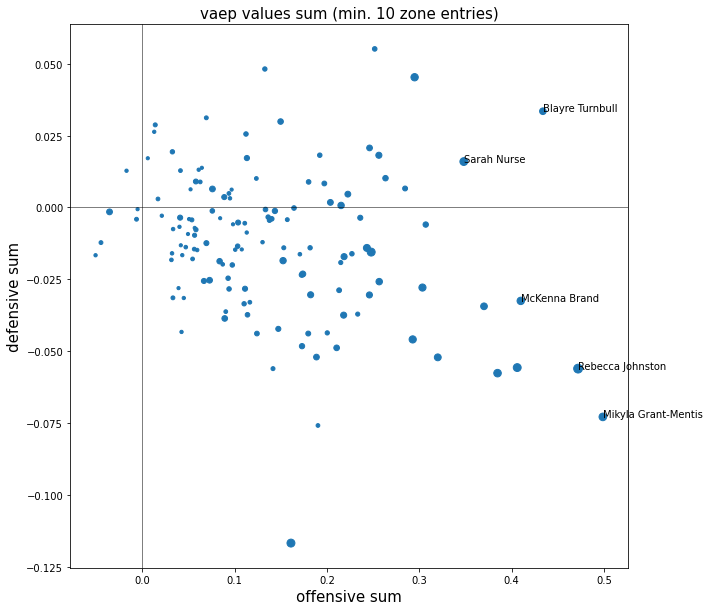

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [197]:
fig2, ax2 = plt.subplots(figsize=(10,10))
plt.scatter(df_ranking_ze_sum_min10['off_value_sum'],df_ranking_ze_sum_min10['def_value_sum'],s=df_ranking_ze_sum_min10['vaep_count'])
ax2.set_xlabel('offensive sum', fontsize=15)
ax2.set_ylabel('defensive sum', fontsize=15)
ax2.set_title('vaep values sum (min. 10 zone entries)', fontsize=15)
ax2.axhline(0, color='black', linewidth=0.5)
ax2.axvline(0, color='black', linewidth=0.5)
for i in range(0,5):
    ax2.annotate(df_ranking_ze_sum_min10.loc[i,'player'],(df_ranking_ze_sum_min10.loc[i,'off_value_sum'],df_ranking_ze_sum_min10.loc[i,'def_value_sum']))
fig2.savefig('sum_vaep.jpg')

What types of zone entries do the Top players Blayre Turnbull and Tori Sullivan do? 

In [205]:
df_final_ze.loc[df_final['player']=='Blayre Turnbull','detail_1'].value_counts()

Carried    27
Dumped     13
Played      4
Name: detail_1, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [206]:
df_final_ze.loc[df_final['player']=='Tori Sullivan','detail_1'].value_counts()

Carried    14
Dumped      6
Played      1
Name: detail_1, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>